In [1]:
import os
import pandas

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *

In [2]:
#import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
os.environ['SPARK_HOME']

'/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6'

In [5]:
spark = SparkSession.builder.master("local[2]").appName("pyspark-jupyter").getOrCreate()

In [6]:
spark

In [7]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=pyspark-jupyter>

In [8]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

In [9]:
FLIGHTS_TRAIN_DATA = 'data/flights20170102.json'
FLIGHTS_TEST_DATA = 'data/flights20170304.json'

In [10]:
schema = StructType([
    StructField("_id", StringType(), nullable=True),
    StructField("dofW", IntegerType(), nullable=True),
    StructField("carrier", StringType(), nullable=True),
    StructField("origin", StringType(), nullable=True),
    StructField("dest", StringType(), nullable=True),
    StructField("crsdephour", IntegerType(), nullable=True),
    StructField("crsdeptime", DoubleType(), nullable=True),
    StructField("depdelay", DoubleType(), nullable=True),
    StructField("crsarrtime", DoubleType(), nullable=True),
    StructField("arrdelay", DoubleType(), nullable=True),
    StructField("crselapsedtime", DoubleType(), nullable=True),
    StructField("dist", DoubleType(), nullable=True)]
  )

In [11]:
train_df = spark.read.json(path=FLIGHTS_TRAIN_DATA, schema=schema).cache()

In [12]:
train_df.count()

41348

In [13]:
train_df.show(5)

+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|                 _id|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|
+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|AA_2017-01-01_ATL...|   7|     AA|   ATL| LGA|        17|    1700.0|     0.0|    1912.0|     0.0|         132.0| 762.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| ATL|        13|    1343.0|     0.0|    1620.0|     0.0|         157.0| 762.0|
|AA_2017-01-01_MIA...|   7|     AA|   MIA| ATL|         9|     939.0|     0.0|    1137.0|    10.0|         118.0| 594.0|
|AA_2017-01-01_ORD...|   7|     AA|   ORD| MIA|        20|    2020.0|     0.0|      26.0|     0.0|         186.0|1197.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| MIA|         7|     700.0|     0.0|    1017.0|     0.0|         197.0|1096.0|
+--------------------+----+-----

In [14]:
test_df = spark.read.json(path=FLIGHTS_TEST_DATA, schema=schema).cache()

In [15]:
test_df.count()

45448

In [16]:
test_df.show(5)

+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|                 _id|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|
+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|WN_2017-03-01_ATL...|   3|     WN|   ATL| BOS|         9|     930.0|     0.0|    1155.0|     0.0|         145.0| 946.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| BOS|        19|    1935.0|   243.0|    2215.0|   210.0|         160.0| 946.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| BOS|        12|    1235.0|    11.0|    1505.0|     0.0|         150.0| 946.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| DEN|        10|    1035.0|    28.0|    1200.0|    59.0|         205.0|1199.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| DEN|        13|    1330.0|    16.0|    1450.0|    29.0|         200.0|1199.0|
+--------------------+----+-----

In [17]:
train_df.describe(["dist", "crselapsedtime", "depdelay", "arrdelay"]).show()

+-------+------------------+------------------+------------------+------------------+
|summary|              dist|    crselapsedtime|          depdelay|          arrdelay|
+-------+------------------+------------------+------------------+------------------+
|  count|             41348|             41348|             41348|             41348|
|   mean|1111.0529167069749|186.26264873754474|15.018719164167553|14.806907226468027|
| stddev| 568.7941212507543| 68.38149648990039| 44.52963204436135| 44.22370513266647|
|    min|             184.0|              64.0|               0.0|               0.0|
|    max|            2704.0|             423.0|            1440.0|            1442.0|
+-------+------------------+------------------+------------------+------------------+



## Data Exploration

We can use Spark SQL to explore the dataset. Here are some example queries using the Spark SQL:

### Register Dataset as a Temporary View in order to explore with SQL

In [18]:
train_df.createOrReplaceTempView("train_flights")

### Top 5 longest departure delays

In [19]:
# Top 5 longest departure delays programmatically
result_df = (train_df
                .select(["carrier", "origin", "dest", "depdelay", "crsdephour", "dist", "dofW"])
                .orderBy(["depdelay"], ascending=[0]).limit(5))

In [20]:
result_df.show()

+-------+------+----+--------+----------+------+----+
|carrier|origin|dest|depdelay|crsdephour|  dist|dofW|
+-------+------+----+--------+----------+------+----+
|     AA|   SFO| ORD|  1440.0|         8|1846.0|   3|
|     DL|   BOS| ATL|  1185.0|        17| 946.0|   6|
|     UA|   DEN| EWR|  1138.0|        12|1605.0|   4|
|     DL|   ORD| ATL|  1087.0|        19| 606.0|   7|
|     UA|   MIA| EWR|  1072.0|        20|1085.0|   1|
+-------+------+----+--------+----------+------+----+



In [21]:
# Top 5 longest departure delays using SQL
sql_result_df = spark.sql("SELECT carrier, origin, dest, depdelay, crsdephour, dist, dofW FROM train_flights ORDER BY depdelay DESC LIMIT 5")

In [22]:
sql_result_df.show()

+-------+------+----+--------+----------+------+----+
|carrier|origin|dest|depdelay|crsdephour|  dist|dofW|
+-------+------+----+--------+----------+------+----+
|     AA|   SFO| ORD|  1440.0|         8|1846.0|   3|
|     DL|   BOS| ATL|  1185.0|        17| 946.0|   6|
|     UA|   DEN| EWR|  1138.0|        12|1605.0|   4|
|     DL|   ORD| ATL|  1087.0|        19| 606.0|   7|
|     UA|   MIA| EWR|  1072.0|        20|1085.0|   1|
+-------+------+----+--------+----------+------+----+



### Average Departure Delay by Carrier

In [23]:
# Average Departure Delay by Carrier using SQL
sql_result_df = spark.sql("SELECT carrier, avg(depdelay) FROM train_flights GROUP BY carrier")

In [24]:
sql_result_df.show()

+-------+------------------+
|carrier|     avg(depdelay)|
+-------+------------------+
|     UA|17.477878450696764|
|     AA| 10.45768118831622|
|     DL|15.316061660865241|
|     WN|13.491000418585182|
+-------+------------------+



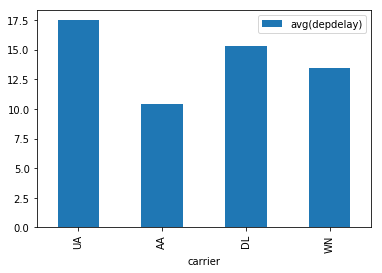

In [25]:
sql_result_df.toPandas().plot(kind='bar', x='carrier');

In [26]:
# Average Departure Delay by Carrier programmatically
result_df = (train_df
                .select(["carrier", "depdelay"])
                .groupBy(["carrier"])
                .avg("depdelay"))

In [27]:
result_df.show()

+-------+------------------+
|carrier|     avg(depdelay)|
+-------+------------------+
|     UA|17.477878450696764|
|     AA| 10.45768118831622|
|     DL|15.316061660865241|
|     WN|13.491000418585182|
+-------+------------------+



### Count of Departure Delays by Carrier (where delay>40 minutes)

We want to predict flight delays where depdelay > 40 minutes, so let’s explore this data. Below, we see that United Airlines and Delta have the highest count of flight delays for January and February 2017 (the training set).

In [28]:
# Count of Departure Delays by Carrier (where delay=40 minutes) using SQL
sql_result_df = spark.sql("SELECT carrier, count(depdelay) FROM train_flights WHERE depdelay > 40 GROUP BY carrier")

In [29]:
sql_result_df.show()

+-------+---------------+
|carrier|count(depdelay)|
+-------+---------------+
|     UA|           2420|
|     AA|            757|
|     DL|           1043|
|     WN|            244|
+-------+---------------+



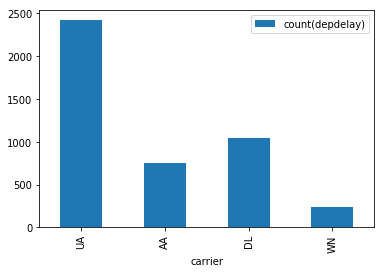

In [30]:
sql_result_df.toPandas().plot(kind='bar', x='carrier');

In [31]:
# Count of Departure Delays by Carrier (where delay=40 minutes) programmatically
result_df = (train_df
                .select(["carrier", "depdelay"])
                .where("depdelay > 40")
                .groupBy(["carrier"])
                .count())

In [32]:
result_df.show()

+-------+-----+
|carrier|count|
+-------+-----+
|     UA| 2420|
|     AA|  757|
|     DL| 1043|
|     WN|  244|
+-------+-----+



### Count of Departure Delays by Day of the Week (1=Monday, 7=Sunday)

In the query below, we see that Monday, Tuesday and Sunday have the highest count of flight delays.

In [33]:
### Count of Departure Delays by Day of the Week (where delay=40 minutes) using SQL
sql_result_df = spark.sql("SELECT dofW, count(depdelay) FROM train_flights WHERE depdelay > 40 GROUP BY dofW ORDER BY dofW")

In [34]:
sql_result_df.show()

+----+---------------+
|dofW|count(depdelay)|
+----+---------------+
|   1|            940|
|   2|            712|
|   3|            482|
|   4|            626|
|   5|            579|
|   6|            424|
|   7|            701|
+----+---------------+



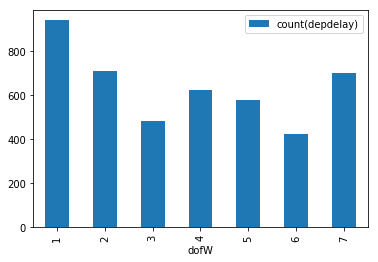

In [35]:
sql_result_df.toPandas().plot(kind='bar', x='dofW');

However, we can see that the days are marked as 1, 2, ... ,7 and not Monday, Tuesday, ... ,Sunday. We can develop a UserDefined function to get the custom labels. UDF (User defined functions) and UDAF (User defined aggregate functions) are key components of big data languages such as Pig and Hive. They allow to extend the language constructs to do adhoc processing on distributed dataset. This can be also applied to Spark. https://ragrawal.wordpress.com/2015/10/02/spark-custom-udf-example/

**Use UDF with DataFrames**

In [36]:
weekday = {1 : "Monday", 2 : "Tuesday", 3 : "Wednesday",  4 : "Thursday", 5 : "Friday", 6 : "Saturday", 7 : "Sunday"}

In [37]:
from pyspark.sql.functions import udf

# Define udf
udfdofwToweekday = udf(lambda x: weekday[x], StringType())

In [38]:
# Instead of a lambda function as in the above cell we could have also defined as a function and registered that as a udf
#def dofwToweekday(x):
#    return weekday[x]
#udfdofwToweekday = udf(dofwToweekday, StringType())

In [39]:
sql_result_df = sql_result_df.withColumn("weekday", udfdofwToweekday("dofW"))

In [40]:
sql_result_df.show()

+----+---------------+---------+
|dofW|count(depdelay)|  weekday|
+----+---------------+---------+
|   1|            940|   Monday|
|   2|            712|  Tuesday|
|   3|            482|Wednesday|
|   4|            626| Thursday|
|   5|            579|   Friday|
|   6|            424| Saturday|
|   7|            701|   Sunday|
+----+---------------+---------+



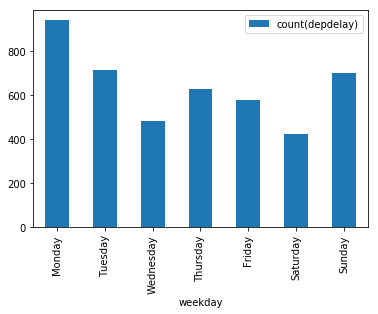

In [41]:
sql_result_df.toPandas()[['weekday', 'count(depdelay)']].plot(kind='bar', x='weekday');

Now we can see that days are marked by names.

In [42]:
# Count of Departure Delays by Day of the Week (where delay=40 minutes) programatically
# We can replicate same aliasing using programatic syntax
result_df = (train_df
                .select(["dofW", udfdofwToweekday("dofW").alias("weekday")])
                .where("depdelay > 40")
                .groupBy(["dofW", "weekday"])
                .count()
                .orderBy(["dofW"]))

In [43]:
result_df.show()

+----+---------+-----+
|dofW|  weekday|count|
+----+---------+-----+
|   1|   Monday|  940|
|   2|  Tuesday|  712|
|   3|Wednesday|  482|
|   4| Thursday|  626|
|   5|   Friday|  579|
|   6| Saturday|  424|
|   7|   Sunday|  701|
+----+---------+-----+



In [44]:
sqlContext.udf.register("udfdofwToweekday", lambda dofW: weekday[dayofW], StringType())

In [45]:
### Count of Departure Delays by Day of the Week (where delay=40 minutes)
#sql_result_df = spark.sql("SELECT dofW, depdelay, sqludfdofwToweekday(dofW) FROM train_flights WHERE depdelay > 40")
sql_result_df = spark.sql("SELECT dofW, udfdofwToweekday(dofW) as weekday, count(depdelay) FROM train_flights WHERE depdelay > 40 GROUP BY dofW, weekday ORDER BY dofW")

In [46]:
sql_result_df.show()

Py4JJavaError: An error occurred while calling o168.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 70.0 failed 1 times, most recent failure: Lost task 0.0 in stage 70.0 (TID 2653, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 177, in main
    process()
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/serializers.py", line 220, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/serializers.py", line 138, in dump_stream
    for obj in iterator:
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/serializers.py", line 209, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 71, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-44-6a0804d918cb>", line 1, in <lambda>
NameError: name 'dayofW' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1499)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1487)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1486)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1486)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1714)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1669)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1658)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2022)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2119)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1008)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1.apply(RDD.scala:1429)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1416)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:133)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:2853)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2153)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2153)
	at org.apache.spark.sql.Dataset$$anonfun$55.apply(Dataset.scala:2837)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:2836)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2153)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2366)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:245)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 177, in main
    process()
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 172, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/serializers.py", line 220, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/serializers.py", line 138, in dump_stream
    for obj in iterator:
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/serializers.py", line 209, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6/python/lib/pyspark.zip/pyspark/worker.py", line 71, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-44-6a0804d918cb>", line 1, in <lambda>
NameError: name 'dayofW' is not defined

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:797)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:335)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
### Count of Departure Delays by Day of the Week (where delay=40 minutes)
sql_result_df = spark.sql("SELECT dofW, udfdofwToweekday(dofW), count(depdelay) FROM train_flights WHERE depdelay > 40 GROUP BY dofW ORDER BY dofW")

In [ ]:
sql_result_df.show()

In [47]:
spark.stop()